# COGS118A FINAL PROJECT

### Comparison of Classification Systems Amongst a Diverse Dataset
#### Joanne Chen, A17516631
#### FA25, 12 / 11 / 25

#### **AI Usage Note:** AI assited CoPilot (ChatGPT) assisted in debugging and formatting of the experimental structure.

# Importing Packages

In [17]:
import os
import io
import zipfile
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings("ignore")

rand_seed = 100
np.random.seed(rand_seed)

data_direct = "."

# Loading Datasets
### Dataset #1 (Easy): Mushroom

In [2]:
def load_mushroom():

    zip_path = os.path.join(data_direct, "mushroom.zip")
    
    with zipfile.ZipFile(zip_path) as zips:
        with zips.open("agaricus-lepiota.data") as file:
            data = pd.read_csv(file, header = None)

    data = data.dropna()
    # === Renaming Columns ===
    data.columns = [f"f{i}" for i in range(data.shape[1])]

    Y = (data["f0"] == "p").astype(int)
    X = data.drop(columns = ["f0"])

    return X, Y

### Dataset #2 (Medium): Predict Student's Dropout and Academic Success

In [3]:
def load_students():

    zip_path = os.path.join(data_direct, "predict+students+dropout+and+academic+success.zip")
    
    with zipfile.ZipFile(zip_path) as zips:
        with zips.open("data.csv") as file:
            data = pd.read_csv(file, sep = ";")

    data = data.dropna()

    Y = (data["Target"] == "Dropout").astype(int)
    X = data.drop(columns = ["Target"])

    return X, Y

### Dataset #3 (Hard): Bank Marketing

In [4]:
def load_bankmarketing():
    
    zip_path = os.path.join(data_direct, "bank.zip")

    with zipfile.ZipFile(zip_path) as zips:
        with zips.open("bank-full.csv") as file:
            data = pd.read_csv(file, sep = ";")

    data = data.dropna()
    
    Y = (data["y"] == "yes").astype(int)
    X = data.drop(columns = ["y"])

    return X, Y

### Data Shapes

In [5]:
datasets = {"Mushroom": load_mushroom(),
            "Students": load_students(),
            "BankMarketing": load_bankmarketing(),
           }

for name, (X, Y) in datasets.items():
    print(f"{name}: Feature Matrix Shape (X) = {X.shape}")

Mushroom: Feature Matrix Shape (X) = (8124, 22)
Students: Feature Matrix Shape (X) = (4424, 36)
BankMarketing: Feature Matrix Shape (X) = (45211, 16)


# Dataset Summary

In [19]:
def dataset_summary_table(datasets, train_size_list, random_state = rand_seed):
    rows = []
    for dataset_name, (X, Y) in datasets.items():
        # ====== Feature Count ======
        n_attr_raw = X.shape[1]

        pre = preprocess(X) 
        pre.fit(X)
        try:
            n_attr_enc = len(pre.get_feature_names_out())
        except Exception:
            n_attr_enc = pre.transform(X[:5]).shape[1]

        poz_pct = 100.0 * float(np.mean(Y))

        for ts in train_size_list:
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = ts, random_state = random_state, stratify = Y)
            rows.append({"Problem": dataset_name,
                         "#Attr": f"{n_attr_raw}/{n_attr_enc}" if n_attr_enc != n_attr_raw else f"{n_attr_raw}",
                         "Train Size": len(X_train),
                         "Test Size": len(X_test),
                         "%Poz": f"{poz_pct:.1f}%"})
    return pd.DataFrame(rows)

dataset_info_df = dataset_summary_table(datasets, train_size_list=[0.2, 0.5, 0.8])
dataset_info_df

,Problem,#Attr,Train Size,Test Size,%Poz
0,Mushroom,22/117,1624,6500,48.2%
1,Mushroom,22/117,4062,4062,48.2%
2,Mushroom,22/117,6499,1625,48.2%
3,Students,36,884,3540,32.1%
4,Students,36,2212,2212,32.1%
5,Students,36,3539,885,32.1%
6,BankMarketing,16/51,904,3617,11.5%
7,BankMarketing,16/51,2260,2261,11.5%
8,BankMarketing,16/51,3616,905,11.5%


# Preprocessing Datasets

In [7]:
def preprocess(X: pd.DataFrame) -> ColumnTransformer:
    numeric_cols = X.select_dtypes(include = ["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include = ["object"]).columns.tolist()

    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy = "median")),
                                            ("scaler", StandardScaler()),
                                           ]
                                  )

    try:
        onehot = OneHotEncoder(handle_unknown = "ignore", sparse_output = True)
    except TypeError:
        onehot = OneHotEncoder(handle_unknown = "ignore", sparse = True)

    categorical_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                                ("onehot", onehot),
                                               ]
                                      )

    pre = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_cols),
                                            ("cat", categorical_transformer, categorical_cols),
                                           ],
                        remainder = "drop",
                        )

    return pre

#=========================================================================================================

def get_models_and_grids(pre: ColumnTransformer, random_state: int = rand_seed):
    models = {}
    param_grids = {}

    # Hyperparameter lists (homework-style naming)
    C_list = [0.01, 0.1, 1.0, 10.0]

    # ====== Logistic Regression ======
    logreg_pipeline = Pipeline(steps = [("pre", pre),
                                        ("clf", LogisticRegression(max_iter = 5000,
                                                                   class_weight = "balanced",
                                                                   random_state = random_state)),
                                       ]
                              )
    models["LogReg"] = logreg_pipeline
    param_grids["LogReg"] = {"clf__C": C_list, "clf__solver": ["lbfgs", "liblinear", "saga"]}

    # ====== Linear SVM ======
    svm_pipeline = Pipeline(steps = [("pre", pre),
                                     ("clf", LinearSVC(class_weight = "balanced",
                                                       max_iter = 30000,
                                                       dual = "auto",
                                                       random_state = random_state)),
                                    ]
                           )
    models["LinearSVM"] = svm_pipeline
    param_grids["LinearSVM"] = {"clf__C": C_list}

    # ====== Random Forest ======
    rf_pipeline = Pipeline(steps = [("pre", pre),
                                    ("clf", RandomForestClassifier(n_estimators = 300,
                                                                   random_state = random_state,
                                                                   n_jobs = -1,
                                                                   class_weight = "balanced_subsample")),
                                   ]
                          )
    models["RandomForest"] = rf_pipeline
    param_grids["RandomForest"] = {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 10]}

    return models, param_grids

# Organizing & Cross-validation

In [8]:
def iter_param_grid(param_grid: dict):
    keys = list(param_grid.keys())
    values = [param_grid[k] for k in keys]
    for combo in itertools.product(*values):
        yield dict(zip(keys, combo))

def set_params(pipeline: Pipeline, params: dict) -> Pipeline:
    pipeline = Pipeline(steps = pipeline.steps)
    pipeline.set_params(**params)
    return pipeline

def cv_mean_accuracy(pipeline: Pipeline, X_train, Y_train, cv: StratifiedKFold):
    fold_acc = []
    for train_idx, val_idx in cv.split(X_train, Y_train):
        X_tr = X_train.iloc[train_idx]
        Y_tr = Y_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        Y_va = Y_train.iloc[val_idx]

        pipeline.fit(X_tr, Y_tr)
        Y_va_pred = pipeline.predict(X_va)
        fold_acc.append(accuracy_score(Y_va, Y_va_pred))
    return float(np.mean(fold_acc))

def select_best_model_via_cv(base_pipeline: Pipeline, param_grid: dict, X_train, Y_train, cv: StratifiedKFold):
    best_params = None
    best_val_acc = -np.inf

    for params in iter_param_grid(param_grid):
        model = set_params(base_pipeline, params)
        val_acc = cv_mean_accuracy(model, X_train, Y_train, cv)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params

    best_model = set_params(base_pipeline, best_params)
    best_model.fit(X_train, Y_train)

    return best_model, best_params, best_val_acc

def run_experiment(X: pd.DataFrame, Y: pd.Series, train_size: float, random_state: int, dataset_name = "Dataset"):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = train_size, stratify = Y, random_state = random_state)

    pre = preprocess(X_train)
    models, grids = get_models_and_grids(pre, random_state = random_state)

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

    rows_list = []

    for model_name, model_pipeline in models.items():
        param_grid = grids[model_name]

        best_model, best_params, best_val_acc = select_best_model_via_cv(base_pipeline = model_pipeline,
                                                                         param_grid = param_grid,
                                                                         X_train = X_train,
                                                                         Y_train = Y_train,
                                                                         cv = cv)
        
        Y_train_pred = best_model.predict(X_train)
        train_acc = accuracy_score(Y_train, Y_train_pred)
        train_f1 = f1_score(Y_train, Y_train_pred)

        Y_test_pred = best_model.predict(X_test)
        test_acc = accuracy_score(Y_test, Y_test_pred)
        test_f1  = f1_score(Y_test,  Y_test_pred)

        rows_list.append({"Dataset": dataset_name,
                          "Classifier": model_name,
                          "Train Size": train_size,
                          "Random State": random_state,
                          "Train Acc.": train_acc,
                          "Val Acc.": best_val_acc,
                          "Test Acc.": test_acc,
                          "Best Param.": best_params,
                          "Train F1": train_f1,
                          "Test F1": test_f1})

    return pd.DataFrame(rows_list)

# Running the Experiments

In [9]:
train_size_list = [0.2, 0.5, 0.8]
n_trials = 3
results_list = []

for dataset_name, (X, Y) in datasets.items():
    for train_size in train_size_list:
        for trial_idx in range(n_trials):
            random_state = rand_seed + trial_idx

            df_trial = run_experiment(X = X, 
                                      Y = Y, 
                                      train_size = train_size,
                                      random_state = random_state,
                                      dataset_name = dataset_name)
            df_trial["Trial"] = trial_idx + 1
            results_list.append(df_trial)

results_df = pd.concat(results_list, ignore_index = True)
results_df

,Dataset,Classifier,Train Size,Random State,Train Acc.,Val Acc.,Test Acc.,Best Param.,Train F1,Test F1,Trial
0,Mushroom,LogReg,0.2,100,1.000000,0.998769,1.000000,"{'clf__C': 10.0, 'clf__solver': 'lbfgs'}",1.000000,1.000000,1
1,Mushroom,LinearSVM,0.2,100,1.000000,0.998769,1.000000,{'clf__C': 1.0},1.000000,1.000000,1
2,Mushroom,RandomForest,0.2,100,1.000000,0.998769,1.000000,"{'clf__n_estimators': 200, 'clf__max_depth': N...",1.000000,1.000000,1
3,Mushroom,LogReg,0.2,101,1.000000,0.998150,0.999077,"{'clf__C': 1.0, 'clf__solver': 'lbfgs'}",1.000000,0.999042,2
4,Mushroom,LinearSVM,0.2,101,1.000000,0.998150,0.999385,{'clf__C': 0.1},1.000000,0.999361,2
...,...,...,...,...,...,...,...,...,...,...,...
76,BankMarketing,LinearSVM,0.8,101,0.851139,0.850448,0.843194,{'clf__C': 10.0},0.560346,0.551266,2
77,BankMarketing,RandomForest,0.8,101,1.000000,0.903451,0.902024,"{'clf__n_estimators': 400, 'clf__max_depth': N...",1.000000,0.451733,2
78,BankMarketing,LogReg,0.8,102,0.845637,0.845029,0.841093,"{'clf__C': 1.0, 'clf__solver': 'lbfgs'}",0.554180,0.549106,3
79,BankMarketing,LinearSVM,0.8,102,0.850448,0.849840,0.846511,{'clf__C': 1.0},0.559205,0.554557,3


# Summarizing Results

In [16]:
model_name_map = {"LogReg": "LOGREG", "LinearSVM": "SVM", "RandomForest": "RANFOR"}
dataset_name_map = {"Mushroom": "Mushroom", "Students": "Students", "BankMarketing": "Bank"}

def make_results_table(results_df, train_size, dataset_order = None):
    if dataset_order is None:
        dataset_order = ["Mushroom", "Students", "BankMarketing"]

    sub = results_df[results_df["Train Size"] == train_size].copy()

    # ====== Average ======
    sub["Model"] = sub["Classifier"].map(model_name_map).fillna(sub["Classifier"])
    sub["Format"] = sub["Dataset"].map(dataset_name_map).fillna(sub["Dataset"])

    mean_df = (sub.groupby(["Model", "Format"], as_index = False)[["Test Acc.", "Test F1", "Train F1"]].mean())

    wide = mean_df.pivot_table(index = "Model", columns = "Format", values = ["Test Acc.", "Test F1", "Train F1"])

    formatted = [dataset_name_map[d] for d in dataset_order]
    cols = []
    for ds in formatted:
        if ("Test Acc.", ds) in wide.columns:  cols.append(("Test Acc.", ds))
        if ("Test F1", ds)  in wide.columns:  cols.append(("Test F1", ds))
        if ("Train F1", ds) in wide.columns:  cols.append(("Train F1", ds))
    wide = wide[cols]

    wide.columns = [f"{ds}-acc" if metric == "Test Acc." else
                    f"{ds}-testf1" if metric == "Test F1" else
                    f"{ds}-trainf1"
                    for (metric, ds) in wide.columns
                   ]

    wide = wide.reset_index().rename(columns={"Model": ""})
    return wide

def display_bold_best(df):
    numeric_cols = df.columns[1:]  # everything except the model column
    sty = df.style.format({c: "{:.3f}" for c in numeric_cols})
    sty = sty.highlight_max(axis=0, subset=numeric_cols, props="font-weight: bold")
    sty = sty.set_table_styles([
        {"selector": "table", "props": [("border-collapse", "collapse")]},
        {"selector": "th, td", "props": [("border", "1px solid black"), ("padding", "4px")]},
    ])
    display(sty)

split_titles = {0.2: "20/80 split:", 0.5: "50/50 split:", 0.8: "80/20 split:"}

for ts in [0.2, 0.5, 0.8]:
    print(split_titles[ts])
    table_df = make_results_table(results_df, ts)
    display_bold_best(table_df)

20/80 split:


,,Mushroom-acc,Mushroom-testf1,Mushroom-trainf1,Students-acc,Students-testf1,Students-trainf1,Bank-acc,Bank-testf1,Bank-trainf1
0,LOGREG,0.999,0.999,1.000,0.859,0.785,0.824,0.843,0.550,0.548
1,RANFOR,1.000,1.000,1.000,0.860,0.760,0.987,0.899,0.370,1.000
2,SVM,0.999,0.999,1.000,0.861,0.786,0.824,0.849,0.555,0.552


50/50 split:


,,Mushroom-acc,Mushroom-testf1,Mushroom-trainf1,Students-acc,Students-testf1,Students-trainf1,Bank-acc,Bank-testf1,Bank-trainf1
0,LOGREG,1.000,1.000,1.000,0.861,0.788,0.801,0.844,0.551,0.554
1,RANFOR,1.000,1.000,1.000,0.868,0.774,0.984,0.901,0.424,1.000
2,SVM,1.000,1.000,1.000,0.865,0.793,0.808,0.850,0.557,0.560


80/20 split:


,,Mushroom-acc,Mushroom-testf1,Mushroom-trainf1,Students-acc,Students-testf1,Students-trainf1,Bank-acc,Bank-testf1,Bank-trainf1
0,LOGREG,1.000,1.000,1.000,0.866,0.795,0.805,0.843,0.552,0.553
1,RANFOR,1.000,1.000,1.000,0.868,0.774,0.976,0.902,0.448,1.000
2,SVM,1.000,1.000,1.000,0.866,0.794,0.804,0.849,0.558,0.559


# Training Data vs Testing Accuracy

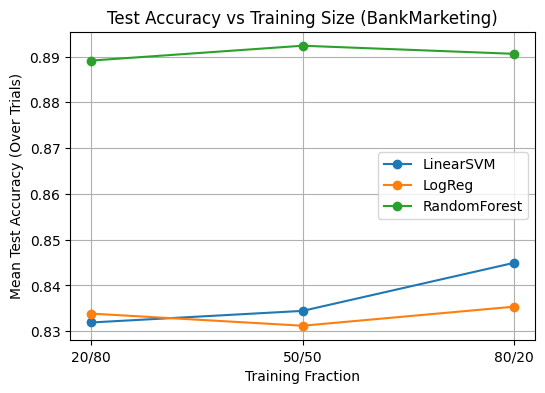

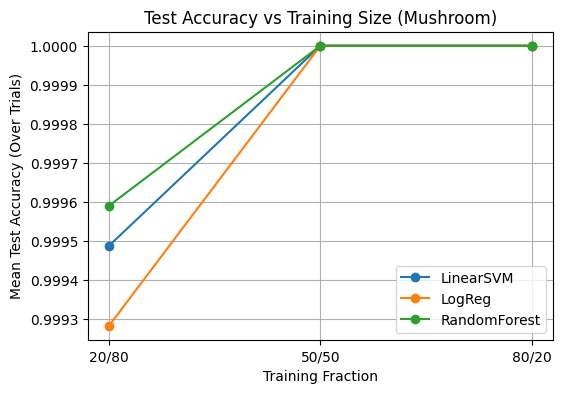

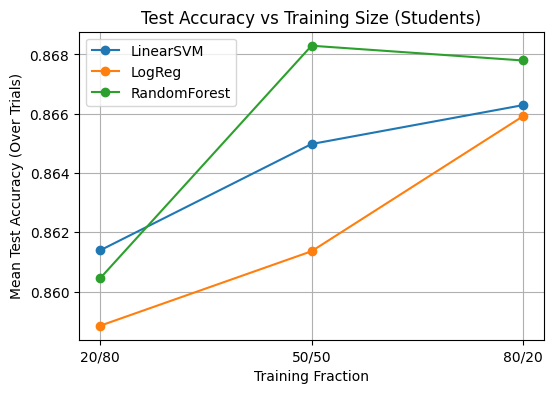

In [20]:
trend_df = (results_df.groupby(["Dataset", "Classifier", "Train Size"], as_index=False)["Test Acc."].mean())

for dataset_name in trend_df["Dataset"].unique():
    sub = trend_df[trend_df["Dataset"] == dataset_name].copy()
    sub = sub.sort_values("Train Size")

    plt.figure(figsize = (6, 4))
    for clf_name in sub["Classifier"].unique():
        sub2 = sub[sub["Classifier"] == clf_name]
        plt.plot(sub2["Train Size"], sub2["Test Acc."], "o-", label=clf_name)

    plt.xlabel("Training Fraction")
    plt.ylabel("Mean Test Accuracy (Over Trials)")
    plt.title(f"Test Accuracy vs Training Size ({dataset_name})")
    plt.xticks([0.2, 0.5, 0.8], ["20/80", "50/50", "80/20"])
    plt.grid(True)
    plt.legend()
    plt.show()

# Additional Graphs / Plots
### Logistics Regression: Learning Curves

In [19]:
def plot_learning_curve_logreg(X: pd.DataFrame, Y: pd.Series, dataset_name = "Dataset", random_state = rand_seed):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, stratify = Y, random_state = random_state)

    pre = preprocess(X_train)

    logreg_pipeline = Pipeline(steps = [("pre", pre), ("clf", LogisticRegression(max_iter = 3000,
                                                                                 C = 1.0,
                                                                                 class_weight = "balanced",
                                                                                 solver = "lbfgs")),
                                       ]
                              )

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

    train_sizes_array, train_scores, val_scores = learning_curve(estimator = logreg_pipeline,
                                                                 X = X_train,
                                                                 y = Y_train,
                                                                 cv = cv,
                                                                 scoring = "accuracy",
                                                                 train_sizes = np.linspace(0.1, 1.0, 6),
                                                                 n_jobs = -1)

    train_mean = train_scores.mean(axis = 1)
    val_mean = val_scores.mean(axis = 1)

    test_scores = []
    for n_train in train_sizes_array:
        X_sub = X_train.iloc[:n_train]
        Y_sub = Y_train.iloc[:n_train]

        logreg_pipeline.fit(X_sub, Y_sub)
        Y_test_pred = logreg_pipeline.predict(X_test)
        test_scores.append(accuracy_score(Y_test, Y_test_pred))

    test_scores = np.array(test_scores)

    plt.figure(figsize = (6, 4))
    plt.plot(train_sizes_array, train_mean, "o-", label = "Training Accuracy")
    plt.plot(train_sizes_array, val_mean, "o-", label = "Validation Accuracy (CV)")
    plt.plot(train_sizes_array, test_scores, "o-", label = "Test Accuracy")
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Accuracy")
    plt.title(f"Logistic Regression — Learning Curve ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Learning Curve for Mushroom

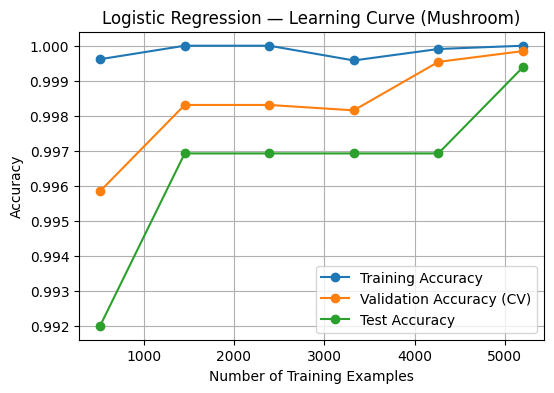

In [20]:
X_mushroom, Y_mushroom = datasets["Mushroom"]
plot_learning_curve_logreg(X_mushroom, Y_mushroom, dataset_name = "Mushroom")

#### Learning Curve for Students

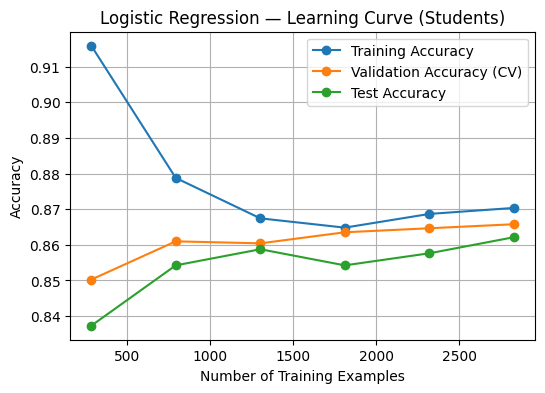

In [21]:
X_students, Y_students = datasets["Students"]
plot_learning_curve_logreg(X_students, Y_students, dataset_name = "Students")

#### Learning Curve for Bank Marketing

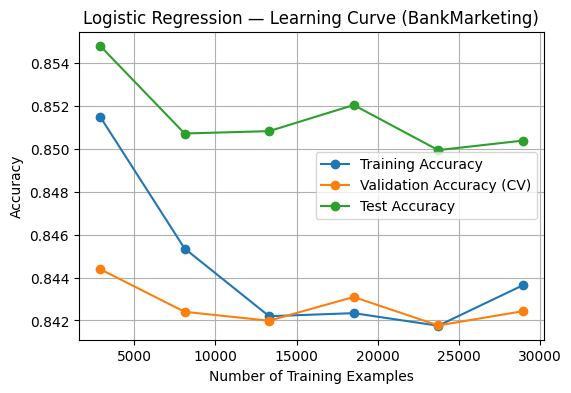

In [22]:
X_bank, Y_bank = datasets["BankMarketing"]
plot_learning_curve_logreg(X_bank, Y_bank, dataset_name = "BankMarketing")

### XGBoost: Heatmaps

In [28]:
def rf_hyperparameter_heatmap(X: pd.DataFrame, Y: pd.Series, dataset_name="Dataset", train_size=0.5, random_state = rand_seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = train_size, stratify = Y, random_state = random_state)

    pre = preprocess(X_train)

    rf_pipeline = Pipeline(steps = [("pre", pre),
                                    ("clf", RandomForestClassifier(random_state = random_state,
                                                                   n_jobs = -1,
                                                                   class_weight = "balanced_subsample")),
                                   ]
                          )

    n_estimators_list = [200, 400, 600]
    max_depth_list = [None, 10, 20]

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)

    score_matrix = np.zeros((len(max_depth_list), len(n_estimators_list)))

    for i, max_depth in enumerate(max_depth_list):
        for j, n_estimators in enumerate(n_estimators_list):
            params = {"clf__max_depth": max_depth, "clf__n_estimators": n_estimators}
            model = set_params(rf_pipeline, params)
            score_matrix[i, j] = cv_mean_accuracy(model, X_train, Y_train, cv)

    plt.figure(figsize = (7, 4))
    im = plt.imshow(score_matrix, origin = "lower", aspect = "auto")
    plt.xticks(range(len(n_estimators_list)), n_estimators_list)
    plt.yticks(range(len(max_depth_list)), [str(d) for d in max_depth_list])
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.colorbar(im, label="CV accuracy")
    plt.title(f"Random Forest CV Accuracy — Heatmap ({dataset_name})")
    plt.show()

#### Heatmap for Mushroom

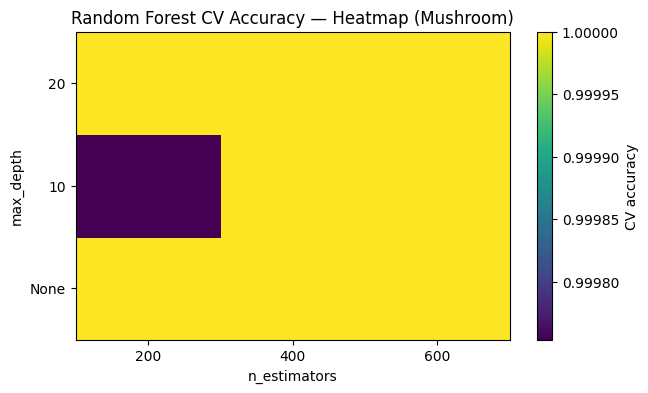

In [29]:
X_mush, Y_mush = datasets["Mushroom"]
rf_hyperparameter_heatmap(X_mush, Y_mush, dataset_name = "Mushroom")

#### Heatmap for Students

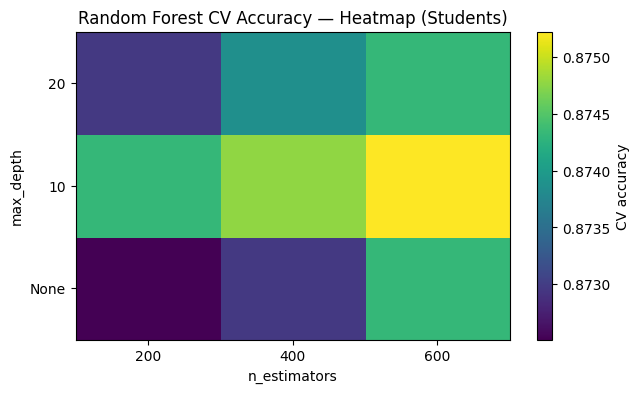

In [30]:
X_students, Y_students = datasets["Students"]
rf_hyperparameter_heatmap(X_students, Y_students, dataset_name = "Students")

#### Learning Curve for Bank Marketing

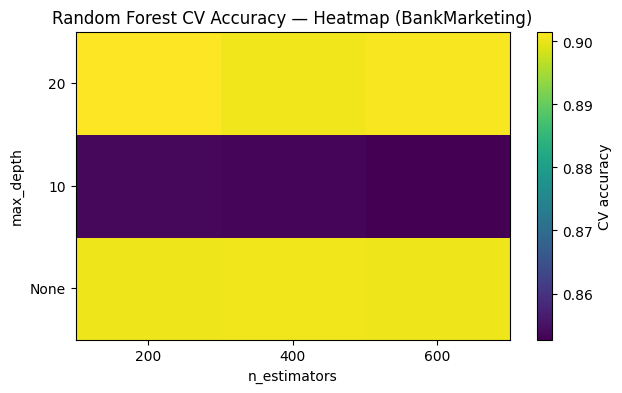

In [31]:
X_bank, Y_bank = datasets["BankMarketing"]
rf_hyperparameter_heatmap(X_bank, Y_bank, dataset_name = "BankMarketing")